In [ ]:
# source colab : https://colab.research.google.com/drive/1WEvMzrBhXR49NaUYLQM4RI-sv0JMBaPr#scrollTo=oqUdZFLuLdCG
!gdown 1Q0quEfLdfBYv9pJ8LJtmCGTizKr2jG-Z
!unzip image_retrieval_dataset.zip

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: images_mr/5415.jpg      
  inflating: images_mr/5416.jpg      
  inflating: images_mr/5417.jpg      
  inflating: images_mr/5418.jpg      
  inflating: images_mr/5419.jpg      
  inflating: images_mr/542.jpg       
  inflating: images_mr/5420.jpg      
  inflating: images_mr/5421.jpg      
  inflating: images_mr/5422.jpg      
  inflating: images_mr/5423.jpg      
  inflating: images_mr/5424.jpg      
  inflating: images_mr/5425.jpg      
  inflating: images_mr/5426.jpg      
  inflating: images_mr/5427.jpg      
  inflating: images_mr/5428.jpg      
  inflating: images_mr/5429.jpg      
  inflating: images_mr/543.jpg       
  inflating: images_mr/5430.jpg      
  inflating: images_mr/5431.jpg      
  inflating: images_mr/5432.jpg      
  inflating: images_mr/5433.jpg      
  inflating: images_mr/5434.jpg      
  inflating: images_mr/5435.jpg      
  inflating: images_mr/5436.jpg      
  inflating: images_mr/5437.jpg

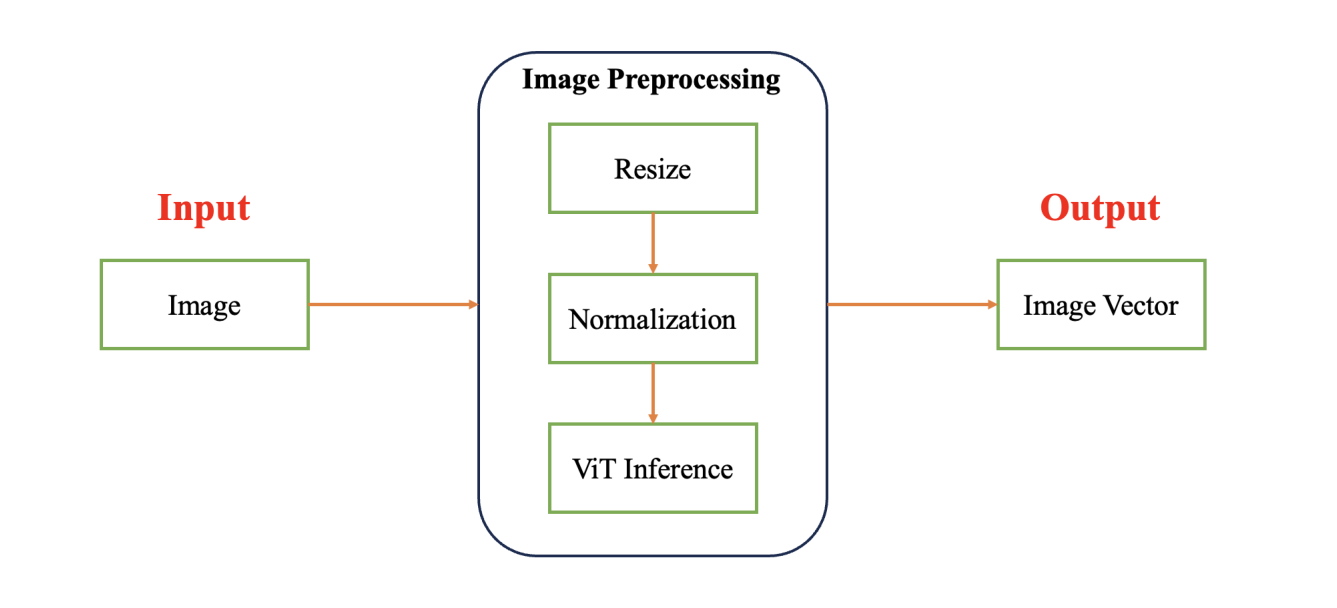

In [ ]:
!pip install transformers==4.31.0 -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 47.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 107.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 84.3 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import cv2
import matplotlib . pyplot as plt
import torch
from transformers import ViTImageProcessor , ViTForImageClassification

In [ ]:
dataset_dir = 'images_mr'
# test 500 images
image_filenames = os.listdir( dataset_dir )[:600]
print(len(image_filenames))
src_images = []
for filename in image_filenames :
  filepath = os.path.join (
    dataset_dir , filename
  )
  image = cv2.imread(filepath)
  image = cv2.cvtColor(
    image , cv2.COLOR_BGR2RGB
  )
  src_images.append(image)

600


In [ ]:
device ='cuda' if torch.cuda.is_available () else'cpu'
# Khai báo ViTImagePreprocessor, dùng để chuẩn hóa ảnh đầu vào trước khi đưa vào mô hình ViT.
processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224")
model = ViTForImageClassification.from_pretrained ("google/vit-base-patch16-224").to( device )

In [ ]:
def preprocessing ( images ):
  # chuan hoa anh dau vao
  inputs = processor (
  images ,
  return_tensors ='pt'
  ).to( device )
  # trich xuat dac trung
  with torch.no_grad ():
    output = model (
    ** inputs ,
    output_hidden_states = True
    ).hidden_states[ -1][: , 0, :].detach().cpu().numpy()

  return output

In [ ]:
preprocessed_src_images = preprocessing(src_images)

In [ ]:
def cosine_similarity ( query_vector , src_vectors ):
  query_norm = np. linalg . norm ( query_vector )
  normalized_query = query_vector / query_norm
  src_norms = np. linalg . norm ( src_vectors , axis =1)
  normalized_src = src_vectors / src_norms [:, np. newaxis ]
  cosine_similarity = np.dot( normalized_src , normalized_query )
  return cosine_similarity

In [ ]:
def ranking ( preprocessed_query_image , preprocessed_src_images , top_k =10) :
  scores = cosine_similarity(
    preprocessed_query_image ,
    preprocessed_src_images
  )
  ranked_list = np.argsort( scores )[:: -1][: top_k ]
  scores = scores[ ranked_list ]

  return ranked_list , scores

Query Image


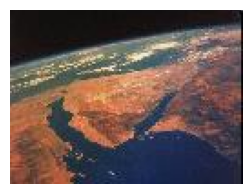

Top 4 results
590


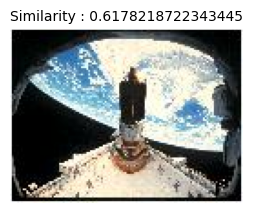

306


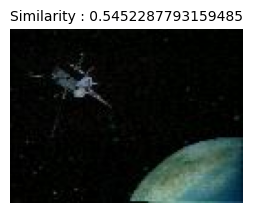

199


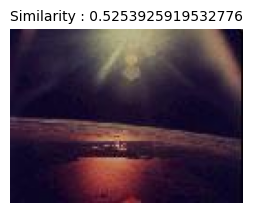

293


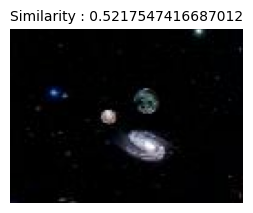

In [ ]:
query_image_paths = [
'/content/images_mr/615.jpg'
]
top_k = 4
for query_image_path in query_image_paths :
  query_image = cv2. imread ( query_image_path , 1)
  query_image = cv2. cvtColor ( query_image , cv2. COLOR_BGR2RGB )
  preprocessed_query_image = preprocessing ( query_image ). squeeze (0)

  ranked_list , scores = ranking (
    preprocessed_query_image ,
    preprocessed_src_images ,
    top_k
  )

  print ('Query Image')
  plt.figure ( figsize =(3 , 3))
  plt.imshow ( query_image )
  plt.axis ('off')
  plt.show ()
  print (f'Top { top_k } results')
  for idx in range (len( ranked_list )):

    src_image_idx = ranked_list [ idx]
    print(src_image_idx)
    similarity_score = scores[idx]
    plt.figure ( figsize =(3 , 3))
    plt.imshow ( src_images [ src_image_idx ])
    plt.title (f'Similarity : { similarity_score }', fontsize =10)
    plt.axis ('off')
    plt.show ()

In [ ]:
inputs = processor (
  src_images[:500] ,
  return_tensors ='pt'
  ).to( device )
  # trich xuat dac trung
with torch.no_grad ():
  output = model (
  ** inputs ,
  output_hidden_states = True
  ).hidden_states[-1]
print(output.shape)


torch.Size([500, 197, 768])
